# Assignment 4

Name: LU Zetian

SID: 20777702

## Problem 1

Given a linear model

$$Y = \sum_{j=1}^p X_j \beta_j + \epsilon$$

where $\beta_j \sim \mathcal{N}(0, \sigma_\beta^2)$ and $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon^2)$. The posterior $p(\beta \mid Y, X, \sigma_\beta^2, \sigma_\epsilon^2)$ is approximated by $q(\beta) = \prod_{j=1}^p q(\beta_j)$. 

Bayesian Linear Regression: Mean-field VB vs Exact Posterior
n=250, p=10, sigma_e2=1.000, sigma_b2=4.000
Max |mu_vb - mu_exact| (inf-norm): 6.883e-15
VB variance underestimation check (ratio = var_vb_diag / var_exact_diag):
  min ratio: 0.953
  max ratio: 0.984


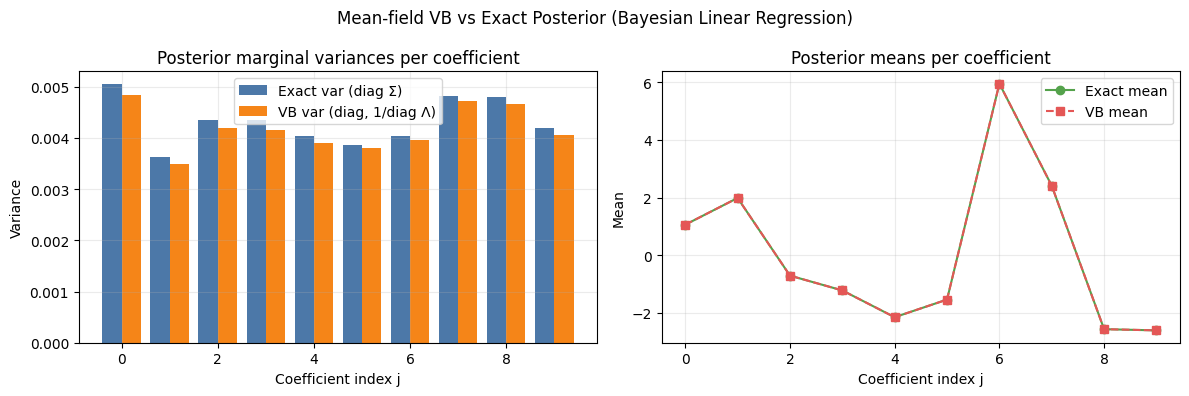

In [48]:
# Simulation: Mean-field VB vs Exact Posterior in Bayesian Linear Regression
# Model: y = X beta + e,  beta ~ N(0, sigma_b2 I),  e ~ N(0, sigma_e2 I)
# Goal: Show VB mean is accurate while VB variance is underestimated vs exact posterior.

import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# ------------------------------
# Helper functions
# ------------------------------

def exact_posterior(X: np.ndarray, y: np.ndarray, sigma_b2: float, sigma_e2: float):
    """
    Exact posterior for Bayesian linear regression with Gaussian prior/noise:
      p(beta | y, X) = N(mu_post, Sigma_post)
    where Lambda_post = X^T X / sigma_e2 + I / sigma_b2,
          Sigma_post = Lambda_post^{-1},
          mu_post    = Sigma_post X^T y / sigma_e2.
    Returns (mu_post, Sigma_post, Lambda_post).
    """
    XtX = X.T @ X
    Lambda = XtX / sigma_e2 + np.eye(X.shape[1]) / sigma_b2
    Sigma = np.linalg.solve(Lambda, np.eye(X.shape[1]))
    mu = Sigma @ (X.T @ y) / sigma_e2
    return mu, Sigma, Lambda


def mean_field_vb_cavi(X: np.ndarray, y: np.ndarray, sigma_b2: float, sigma_e2: float,
                       max_iter: int = 10_000, tol: float = 1e-10):
    """
    Coordinate-ascent variational inference (CAVI) for the mean-field approximation
      q(beta) = prod_j q_j(beta_j) where each q_j is Gaussian.
    For the linear-Gaussian model, the optimal factors have:
      var_j = 1 / ( (||x_j||^2 / sigma_e2) + 1/sigma_b2 )  (does not depend on other coords)
      mean updates (cyclic):
        mu_j <- var_j * ( x_j^T ( y - X mu + x_j mu_j ) ) / sigma_e2
    Returns (mu_vb, var_vb_diag).
    """
    n, p = X.shape
    # Precompute feature norms
    x_col_norm2 = np.sum(X * X, axis=0)  # shape (p,)
    var_diag = 1.0 / (x_col_norm2 / sigma_e2 + 1.0 / sigma_b2)

    mu = np.zeros(p)
    r = y.copy()  # residual r = y - X mu

    for _ in range(max_iter):
        mu_old = mu.copy()
        for j in range(p):
            # Remove current contribution of feature j
            r += X[:, j] * mu[j]
            # Update mean_j using current residual
            rho_j = X[:, j] @ r
            mu[j] = var_diag[j] * (rho_j / sigma_e2)
            # Add back new contribution
            r -= X[:, j] * mu[j]
        if np.linalg.norm(mu - mu_old, ord=np.inf) < tol:
            break
    return mu, var_diag

# ------------------------------
# Simulation setup
# ------------------------------

n = 250
p = 10
X = np.random.randn(n, p)

sigma_e = 1.0
sigma_e2 = sigma_e ** 2
sigma_b = 2.0
sigma_b2 = sigma_b ** 2

beta_true = sigma_b * np.random.randn(p)

y = X @ beta_true + sigma_e * np.random.randn(n)

# ------------------------------
# Compute exact posterior and mean-field VB approximation
# ------------------------------
mu_exact, Sigma_exact, Lambda_exact = exact_posterior(X, y, sigma_b2, sigma_e2)
mu_vb, var_vb_diag = mean_field_vb_cavi(X, y, sigma_b2, sigma_e2, max_iter=20_000, tol=1e-12)

# Mean comparison
mean_diff_inf = float(np.max(np.abs(mu_vb - mu_exact)))

# Variance comparison
var_exact_diag = np.diag(Sigma_exact)
var_ratio = var_vb_diag / var_exact_diag

# ------------------------------
# Report metrics
# ------------------------------
print("Bayesian Linear Regression: Mean-field VB vs Exact Posterior")
print(f"n={n}, p={p}, sigma_e2={sigma_e2:.3f}, sigma_b2={sigma_b2:.3f}")
print(f"Max |mu_vb - mu_exact| (inf-norm): {mean_diff_inf:.3e}")
print(f"VB variance underestimation check (ratio = var_vb_diag / var_exact_diag):")
print(f"  min ratio: {float(np.min(var_ratio)):.3f}")
print(f"  max ratio: {float(np.max(var_ratio)):.3f}")

# ------------------------------
# Visualization: compare diagonal variances and means
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Variances
idx = np.arange(p)
axes[0].bar(idx - 0.2, var_exact_diag, width=0.4, label='Exact var (diag Σ)', color='#4c78a8')
axes[0].bar(idx + 0.2, var_vb_diag, width=0.4, label='VB var (diag, 1/diag Λ)', color='#f58518')
axes[0].set_title('Posterior marginal variances per coefficient')
axes[0].set_xlabel('Coefficient index j')
axes[0].set_ylabel('Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.25)

# Means
axes[1].plot(idx, mu_exact, 'o-', label='Exact mean', color='#54a24b')
axes[1].plot(idx, mu_vb, 's--', label='VB mean', color='#e45756')
axes[1].set_title('Posterior means per coefficient')
axes[1].set_xlabel('Coefficient index j')
axes[1].set_ylabel('Mean')
axes[1].legend()
axes[1].grid(True, alpha=0.25)

plt.suptitle('Mean-field VB vs Exact Posterior (Bayesian Linear Regression)')
plt.tight_layout()
plt.show()


## Problem 2

The Lasso problem: 

$$\hat\beta(\lambda) = \min_{\beta_1, ..., \beta_p} \frac{1}{2} \sum_{i=1}^n (y_i - \sum_{j=1}^p x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^p |\beta_j| = \min_{\beta_1, ..., \beta_p} \sum_{i=1}^n (y_i - \sum_{j=1}^p x_{ij} \beta_j)^2 + 2 \lambda \sum_{j=1}^p |\beta_j|$$

Another problem:

$$(\hat{u}(\lambda), \hat{v}(\lambda)) = \min_{u_1, ..., u_p; v_1, ..., v_p} \sum_{i=1}^n (y_i - \sum_{j=1}^p x_{ij} u_j v_j)^2 + \lambda \sum_{j=1}^p (u_j^2 + v_j^2)$$

$$\tilde\beta_j(\lambda) = \hat{u}_j(\lambda) \hat{v}_j(\lambda) \, \text{ for } \, j = 1, ..., p$$

Max |tilde_beta(lambda) - lasso_beta(2*lambda)| across grid: 1.396e-09


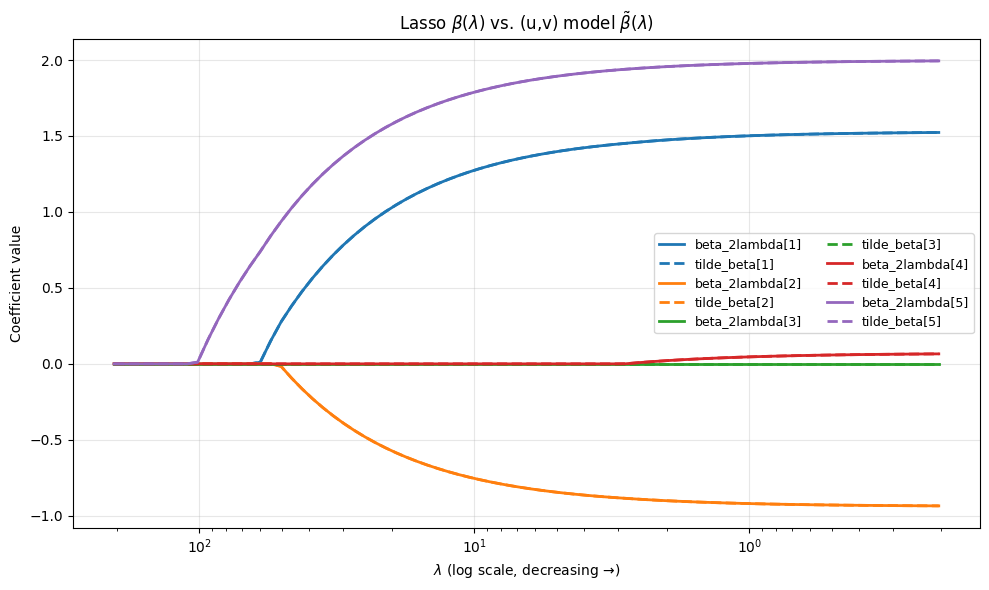

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# ------------------------------
# Helper functions
# ------------------------------

def soft_threshold(z: np.ndarray, lam: float) -> np.ndarray:
    """Soft-thresholding operator applied elementwise."""
    return np.sign(z) * np.maximum(np.abs(z) - lam, 0.0)


def lasso_coordinate_descent(X: np.ndarray, y: np.ndarray, lam: float,
                             beta_init: np.ndarray | None = None,
                             max_iter: int = 4000, tol: float = 1e-8) -> np.ndarray:
    """
    Solve: min_beta 1/2 ||y - X beta||_2^2 + lam * ||beta||_1
    via cyclic coordinate descent with soft-thresholding.
    This uses the objective form shown in the notebook (no 1/n factors).
    """
    n, p = X.shape
    beta = np.zeros(p) if beta_init is None else beta_init.copy()
    X_col_norm2 = np.sum(X * X, axis=0) + 1e-20  # avoid divide-by-zero

    for _ in range(max_iter):
        beta_old = beta.copy()
        # Coordinate updates
        for j in range(p):
            # r_j = y - X beta + x_j * beta_j
            r_j = y - X @ beta + X[:, j] * beta[j]
            rho_j = X[:, j] @ r_j
            beta[j] = soft_threshold(rho_j, lam) / X_col_norm2[j]
        # Convergence check
        if np.linalg.norm(beta - beta_old, ord=np.inf) < tol:
            break
    return beta


def uv_alternating_minimization(X: np.ndarray, y: np.ndarray, lam: float,
                                u0: np.ndarray | None = None,
                                v0: np.ndarray | None = None,
                                max_iter: int = 1000, tol: float = 1e-10) -> tuple[np.ndarray, np.ndarray]:
    """
    Solve: min_{u, v} 1/2 ||y - sum_j x_j u_j v_j||_2^2 + lam * sum_j (u_j^2 + v_j^2)
    by alternating minimization (each subproblem is ridge regression in closed form).

    For fixed v, define Z = X * v (column-wise scale) and solve (Z^T Z + 2*lam I) u = Z^T y.
    For fixed u, define W = X * u and solve (W^T W + 2*lam I) v = W^T y.
    """
    n, p = X.shape
    u = np.zeros(p) if u0 is None else u0.copy()
    v = np.ones(p) if v0 is None else v0.copy()

    for _ in range(max_iter):
        uv_old = u * v
        # Update u given v (ridge)
        Z = X * v  # broadcast multiply columns by v_j
        A_u = Z.T @ Z + 2.0 * lam * np.eye(p)
        b_u = Z.T @ y
        u = np.linalg.solve(A_u, b_u)

        # Update v given u (ridge)
        W = X * u
        A_v = W.T @ W + 2.0 * lam * np.eye(p)
        b_v = W.T @ y
        v = np.linalg.solve(A_v, b_v)

        # Check convergence on product (which defines tilde beta)
        if np.linalg.norm(u * v - uv_old, ord=np.inf) < tol:
            break
    return u, v


# ------------------------------
# Simulation setup
# ------------------------------

n = 100
p = 5
X = np.random.randn(n, p)
# True sparse-ish coefficients for clarity
beta_true = np.array([1.5, -1.0, 0.0, 0.0, 2.0])
# beta_true = np.random.randn(p)
noise = 0.5 * np.random.randn(n)
y = X @ beta_true + noise

# Lambda grid: from lambda_max (all-zero solution) down to small fraction
lambda_max = float(np.max(np.abs(X.T @ y)))
lambda_min = lambda_max * 1e-3
lambdas = np.logspace(np.log10(lambda_max), np.log10(lambda_min), 80)

# ------------------------------
# Compute Lasso path (beta) and (u, v) path (tilde beta = u * v)
# ------------------------------

beta_path = np.zeros((len(lambdas), p))
tilde_path = np.zeros((len(lambdas), p))
# We'll also compute the Lasso path at 2*lambda for comparison
beta_2lam_path = np.zeros_like(beta_path)

# Warm starts for faster convergence across the path
beta_ws = np.zeros(p)
beta2_ws = np.zeros(p)

# u,v warm-starts will be constructed from the current lasso solution at 2*lambda
u_ws = np.zeros(p)
v_ws = np.ones(p)

for t, lam in enumerate(lambdas):
    # Lasso solution at lambda
    beta_ws = lasso_coordinate_descent(X, y, lam, beta_init=beta_ws, max_iter=4000, tol=1e-8)
    beta_path[t, :] = beta_ws

    # Lasso solution at 2*lambda (theoretically equals tilde_beta(lambda))
    beta2_ws = lasso_coordinate_descent(X, y, 2.0 * lam, beta_init=beta2_ws, max_iter=4000, tol=1e-8)
    beta_2lam_path[t, :] = beta2_ws

    # Initialize (u, v) close to the expected solution using factorization of beta2
    # If beta2_j = s_j * a_j with a_j >= 0, set u0_j = s_j * sqrt(a_j), v0_j = sqrt(a_j)
    s = np.sign(beta2_ws)
    a = np.sqrt(np.abs(beta2_ws))
    u0 = s * a
    v0 = a.copy()

    # Refine with alternating minimization at current lambda
    u_ws, v_ws = uv_alternating_minimization(X, y, lam, u0=u0, v0=v0, max_iter=1000, tol=1e-10)
    tilde_path[t, :] = u_ws * v_ws

# Check empirical equivalence: tilde_beta(lam) ~ lasso_beta(2*lam)
max_diff_equiv = float(np.max(np.abs(tilde_path - beta_2lam_path)))
print(f"Max |tilde_beta(lambda) - lasso_beta(2*lambda)| across grid: {max_diff_equiv:.3e}")

# ------------------------------
# Plot paths: beta(lambda) vs tilde_beta(lambda)
# ------------------------------

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # distinct colors for up to 10 lines
for j in range(p):
    c = colors[j % len(colors)]
    # plt.plot(lambdas, beta_path[:, j], color=c, linewidth=2, label=f"beta[{j+1}]")
    plt.plot(lambdas, beta_2lam_path[:, j], color=c, linewidth=2, label=f"beta_2lambda[{j+1}]")
    plt.plot(lambdas, tilde_path[:, j], color=c, linestyle="--", linewidth=2, label=f"tilde_beta[{j+1}]")

plt.xscale('log')
plt.gca().invert_xaxis()  # show from large -> small lambda
plt.xlabel(r"$\lambda$ (log scale, decreasing →)")
plt.ylabel(r"Coefficient value")
plt.title(r"Lasso $\beta(\lambda)$ vs. (u,v) model $\tilde{\beta}(\lambda)$")
plt.legend(ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Surprisingly, the two solution path $\beta(\lambda)$ and $\tilde\beta(\lambda)$ are exactly the same. Since $\tilde\beta_j = v_j u_j$, we have $v_j = \frac{\tilde\beta_j}{u_j}$, then $\min_{u_j} u_j^2 + v_j^2 = \min_{u_j} u_j^2 + \frac{\tilde\beta_j}{u_j}$. By setting the derivative to zero, we have $u_j^4 = \tilde\beta_j^2 \Rightarrow |u_j| = |\tilde\beta_j|^\frac{1}{2} \Rightarrow |v_j| = |\tilde\beta_j|^\frac{1}{2}$. So $u_j^2 + v_j^2 = 2|\tilde\beta|$. This shows some equivalence between $\beta(\lambda)$ and $\tilde\beta(\lambda)$. 

## Problem 3

Max |log-marginal-likelihood - optimal ELBO| over q=0..127: 4.366e-11


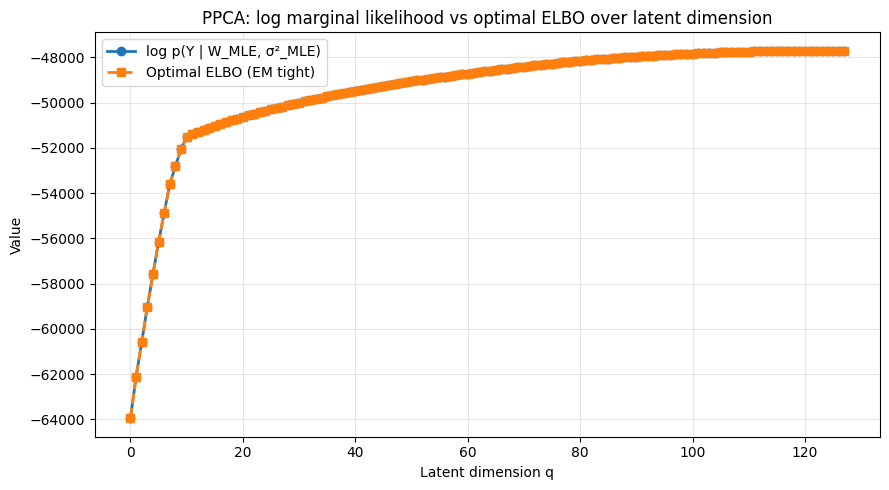

In [53]:
# Probabilistic PCA: compare log marginal likelihood and optimal ELBO vs latent dimension
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# ------------------------------
# Simulate data from a PPCA model
# ------------------------------
n = 500       # samples
d = 128       # observed dimension
q_true = 10   # true latent dimension
sigma_true = 0.5
sigma2_true = sigma_true ** 2

# Construct a well-conditioned W_true with decaying singular values
U, _ = np.linalg.qr(np.random.randn(d, d))
W_true = U[:, :q_true] @ np.diag(np.linspace(2.0, 1.0, q_true))  # d x q_true

Z = np.random.randn(n, q_true)              # n x q_true
E = sigma_true * np.random.randn(n, d)
Y = Z @ W_true.T + E                         # n x d

# Y is a low-rank plus noise dataset
# Center data (PPCA assumes zero-mean)
Y = Y - Y.mean(axis=0, keepdims=True)
S = (Y.T @ Y) / n                            # empirical covariance (d x d)

def fit_ppca_mle_from_cov(S: np.ndarray, q: int) -> tuple[np.ndarray, float]:
    """
    Closed-form MLE for PPCA parameters (W, sigma^2) using eigen-decomposition of S.
    Returns W (d x q) and sigma2 (scalar). For q=0, W has shape (d, 0).
    """
    d = S.shape[0]
    # Eigen-decomposition of covariance
    evals, evecs = np.linalg.eigh(S)          # ascending order
    order = np.argsort(evals)[::-1]
    evals = evals[order]
    evecs = evecs[:, order]

    if q == 0:
        sigma2 = float(np.mean(evals))
        W = np.zeros((d, 0))
        return W, max(sigma2, 1e-12)

    if q >= d:
        raise ValueError("Latent dimension q must be < d for PPCA.")

    # MLE noise variance is the average of remaining eigenvalues
    tail = evals[q:]
    sigma2 = float(np.mean(tail)) if len(tail) > 0 else 0.0
    sigma2 = max(sigma2, 1e-12)

    # Loadings: W = U_q (Lambda_q - sigma2 I)^{1/2} R, take R = I
    Lq = np.maximum(evals[:q] - sigma2, 0.0)
    W = evecs[:, :q] @ np.diag(np.sqrt(Lq))
    return W, sigma2


def log_marginal_likelihood_from_Y(Y: np.ndarray, W: np.ndarray, sigma2: float) -> float:
    """
    Compute exact log p(Y | W, sigma2) by integrating out z, using Woodbury identities.
    This version operates directly on Y for numerical consistency with the ELBO.
    """
    n, d = Y.shape
    q = W.shape[1]

    if q == 0:
        logdetC = d * np.log(sigma2)
        quad = (Y * Y).sum() / sigma2
        return -0.5 * (n * d * np.log(2 * np.pi) + n * logdetC + quad)

    WtW = W.T @ W                              # q x q
    A = np.eye(q) + (WtW / sigma2)            # q x q
    signA, logdetA = np.linalg.slogdet(A)
    if signA <= 0:
        eigA = np.linalg.eigvalsh(A)
        logdetA = np.sum(np.log(np.maximum(eigA, 1e-30)))

    # log|C| = d log sigma2 + log|A|
    logdetC = d * np.log(sigma2) + logdetA

    # y_i^T C^{-1} y_i = (1/sigma2) ||y_i||^2 - (1/sigma2^2) y_i^T W A^{-1} W^T y_i
    Ainv = np.linalg.solve(A, np.eye(q))
    YtY = (Y * Y).sum()
    WY = W.T @ Y.T                    # q x n
    quad_corr = np.sum(WY * (Ainv @ WY))   # sum over i of y_i^T W A^{-1} W^T y_i
    quad = (YtY / sigma2) - (quad_corr / (sigma2 ** 2))

    return -0.5 * (n * d * np.log(2 * np.pi) + n * logdetC + quad)


def optimal_elbo(Y: np.ndarray, W: np.ndarray, sigma2: float) -> float:
    """
    ELBO with q(z_i) = p(z_i | y_i, W, sigma2) (tight bound at EM optimum).
    Returns sum over i of ELBO_i.
    """
    n, d = Y.shape
    q = W.shape[1]
    if q == 0:
        return log_marginal_likelihood_from_Y(Y, W, sigma2)

    WtW = W.T @ W                              # q x q
    A = np.eye(q) + (WtW / sigma2)            # q x q
    Sigma = np.linalg.solve(A, np.eye(q))     # posterior covariance of z_i

    # Posterior means: m_i = (1/sigma2) Sigma W^T y_i
    B = (Sigma @ W.T) / sigma2                # q x d
    M = Y @ B.T                               # n x q

    # Terms needed
    tr_Sigma = float(np.trace(Sigma))
    signS, logdetSigma = np.linalg.slogdet(Sigma)
    if signS <= 0:
        eigS = np.linalg.eigvalsh(Sigma)
        logdetSigma = float(np.sum(np.log(np.maximum(eigS, 1e-30))))

    # E[log p(z)]
    E_log_pz = -0.5 * n * q * np.log(2 * np.pi) - 0.5 * n * tr_Sigma - 0.5 * np.sum(M * M)

    # E[log p(y|z)]
    resid = Y - M @ W.T
    quad = (resid ** 2).sum()
    tr_WSigmaWt = float(np.trace(W @ Sigma @ W.T))
    E_log_py_z = -0.5 * (n * d * np.log(2 * np.pi * sigma2) + (quad + n * tr_WSigmaWt) / sigma2)

    # Entropy H[q]
    Hq = 0.5 * n * (q * (1.0 + np.log(2 * np.pi)) + logdetSigma)

    return E_log_pz + E_log_py_z + Hq

# ------------------------------
# Sweep latent dimension and compare
# ------------------------------
q_max = d - 1
ll_list = []
elbo_list = []

for q in range(q_max + 1):
    W_hat, sigma2_hat = fit_ppca_mle_from_cov(S, q)
    ll = log_marginal_likelihood_from_Y(Y, W_hat, sigma2_hat)
    elbo = optimal_elbo(Y, W_hat, sigma2_hat)
    ll_list.append(ll)
    elbo_list.append(elbo)

ll_arr = np.array(ll_list)
elbo_arr = np.array(elbo_list)
max_abs_gap = np.max(np.abs(ll_arr - elbo_arr))
print(f"Max |log-marginal-likelihood - optimal ELBO| over q=0..{q_max}: {max_abs_gap:.3e}")

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(9, 5))
qs = np.arange(q_max + 1)
plt.plot(qs, ll_arr, marker='o', linewidth=2, label='log p(Y | W_MLE, σ²_MLE)')
plt.plot(qs, elbo_arr, marker='s', linestyle='--', linewidth=2, label='Optimal ELBO (EM tight)')
plt.xlabel('Latent dimension q')
plt.ylabel('Value')
plt.title('PPCA: log marginal likelihood vs optimal ELBO over latent dimension')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()